In [1]:
!pip install deap keras tensorflow matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.6 MB/s eta 0:00:00


In [2]:
import random
import numpy as np
from deap import base, creator, tools, algorithms
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from keras.datasets import cifar10
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


1. We are first normalizing the inputs, since the input is a range from (0 to 255), we normalise them from 0 to 1, this helps during converging as they converge faster and even scaling enables the network to learn patterns more efficiently \\
2. We then do one-hot encoding since we will be using categorical crossentropy as our loss function, since the problem is a multi-class classification and this requires that all the classes be one-hot encoded

In [4]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

num_classes = y_test.shape[1]
input_shape = x_train.shape[1:]

In [5]:
def create_cnn(architecture):
    model = Sequential()
    added_flatten = False

    for layer in architecture:
        if layer['type'] == 'conv' and not added_flatten:
            model.add(Conv2D(layer['filters'], (3, 3), activation=layer['activation'], input_shape=input_shape))
            model.add(MaxPooling2D(pool_size=(2, 2)))
        elif layer['type'] == 'dense':
            if not added_flatten:
                model.add(Flatten())
                added_flatten = True
            model.add(Dense(layer['units'], activation=layer['activation']))

    if not added_flatten:
        model.add(Flatten())

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [6]:
architecture = [
    {'type': 'conv', 'filters': 32, 'activation': 'relu'},
    {'type': 'conv', 'filters': 64, 'activation': 'relu'},
    {'type': 'conv', 'filters': 64, 'activation': 'relu'},
    {'type': 'dense', 'units': 128, 'activation': 'relu'},
]

model = create_cnn(architecture)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 90,506 (353.54 KB)

 Trainable params: 90,506 (353.54 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
!pip install pydot graphviz

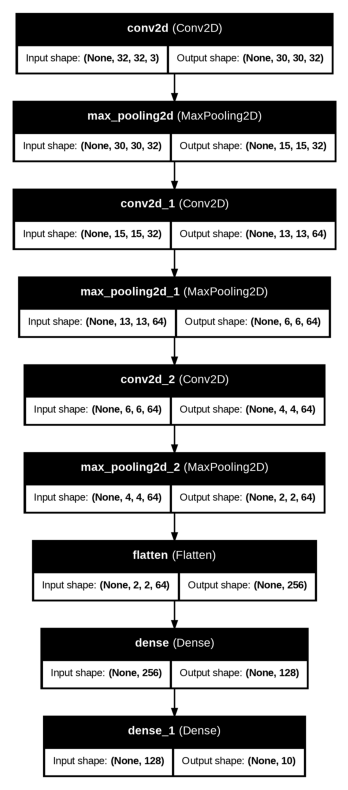

In [9]:
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
img = mpimg.imread('model_plot.png')
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

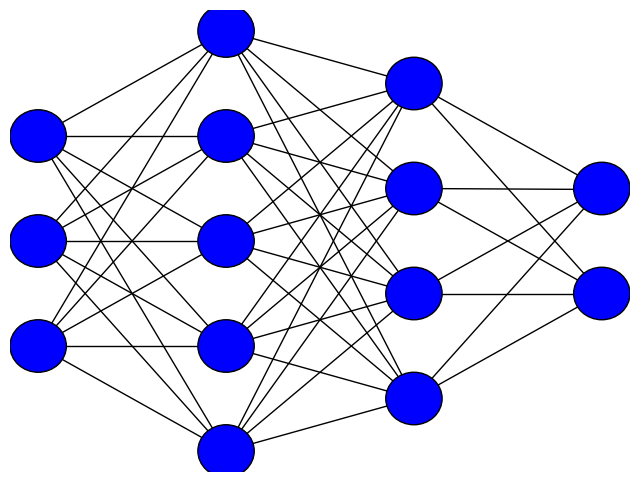

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def draw_neural_net(ax, layer_sizes):
    '''
    Draw a neural network cartoon using matplotlib.

    ax : matplotlib.axes.AxesSubplot
        The axes on which to plot the cartoon.
    layer_sizes : list of int
        List containing the number of neurons in each layer.
    '''
    # Vertical distance between layers
    v_spacing = 1 / float(max(layer_sizes))
    # Horizontal distance between layers
    h_spacing = 1 / float(len(layer_sizes) - 1)

    # Positions of neurons in the plot
    neuron_coords = []

    # Loop over the layers and plot the neurons
    for n, layer_size in enumerate(layer_sizes):
        layer_x = n * h_spacing  # X position for all neurons in this layer
        y_positions = np.linspace(0.5 - (layer_size - 1) * v_spacing / 2,
                                  0.5 + (layer_size - 1) * v_spacing / 2,
                                  layer_size)
        neuron_coords.append(list(zip([layer_x] * layer_size, y_positions)))
        for y in y_positions:
            circle = plt.Circle((layer_x, y), v_spacing / 4, color='b', ec='k', zorder=4)
            ax.add_artist(circle)

    # Loop over the connections between neurons
    for (layer1, layer2) in zip(neuron_coords[:-1], neuron_coords[1:]):
        for (x1, y1) in layer1:
            for (x2, y2) in layer2:
                ax.plot([x1, x2], [y1, y2], 'k-', lw=1)

# Define the architecture: list of neurons in each layer
layer_sizes = [3, 5, 4, 2]  # Example architecture

fig = plt.figure(figsize=(8, 6))
ax = fig.gca()
ax.axis('off')  # Turn off the axis

# Draw the network
draw_neural_net(ax, layer_sizes)

plt.show()
